PAPERSPACE VERSION

In [1]:
#! pip install comet-ml

In [2]:
# should be from pytorch_lightning.loggers import CometLogger
from pytorch_lightning.loggers.comet import CometLogger

In [3]:
import glob
from PIL import Image
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [4]:
from torch.optim.lr_scheduler import StepLR

In [5]:
import pytorch_lightning as pl

In [6]:
%load_ext tensorboard

In [7]:
from pytorch_lightning.core.lightning import LightningModule

In [8]:
# import zipfile

In [9]:
# with zipfile.ZipFile('./storage/GalaxyDataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('./storage')

# Homework 2, part 1

## transfer learning
1. below you will find the dataset object for the galaxy dataset from homework 1, except that now it outputs a 69x69 image (no flattening), and the single grayscale channel is repeated 3 times to give a 3x69x69 image

2. load a pre-trained network from pytorchs selection https://pytorch.org/docs/stable/torchvision/models.html

3. create a network to classify the galaxy image dataset with some parts from the pretrained network

4. train the new network

5. when you reach over 75% accuracy on the validation dataset, submit your trained model (state_dict and source code)

6. double check that if you train the same model without the pre-trained weights, it will perform worse (no need to submit this model) 

In [10]:
path_to_training_data = './storage/GalaxyDataset/train/'
path_to_validation_data = './storage/GalaxyDataset/validation/'

In [11]:
import glob
from PIL import Image
from PIL import ImageFilter
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


class CustomDataset(Dataset):
    def __init__(self, path,mean=0.092,std=0.127,n_classes=10,transform=False):
        
        self.mean = mean
        self.std = std
        
        self.do_transform = transform
        self.transform = transforms.RandomRotation(180)
        
        self.filelist = glob.glob(path+'/*.png')
        
        self.labels = np.zeros(len(self.filelist))
        
        for class_i in range(n_classes):
            self.labels[ np.array(['class'+str(class_i) in x for x in self.filelist]) ] = class_i
        self.labels = torch.LongTensor(self.labels)
        
        
    def __len__(self):
       
        return len(self.filelist)

    def __getitem__(self, idx):
        
        img = Image.open(self.filelist[idx])
    
        if self.do_transform:
            
            img = self.transform(img)
        
        
        x = transforms.ToTensor()(img)
        
        x = (x-self.mean)/self.std
        # vgg16 inp RGB (3 channels). natively in grayscale, repeat channel 3x
        x = x.repeat(3,1,1)
        
        
        class_label = self.labels[idx]
        
        return x, class_label

In [12]:
train_ds = CustomDataset(path_to_training_data,transform=False)
valid_ds = CustomDataset(path_to_validation_data,transform=False)

In [13]:
len(train_ds.labels)

10000

In [14]:
len(valid_ds.labels)

5000

In [15]:
x,y = train_ds[553]

In [16]:
x.shape

torch.Size([3, 69, 69])

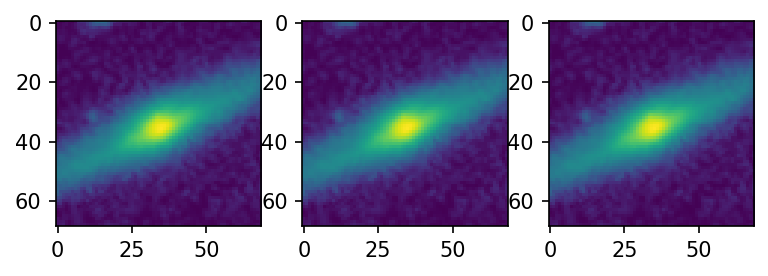

In [17]:
fig,ax = plt.subplots(1,3,figsize=(6,2),dpi=150)

for i in range(3):
    ax[i].imshow(x[i])

In [81]:
NUM_CLASSES = 10
BATCH_SIZE = 32
FEAT_EXTRACT = True
LOSS_FUNC = F.cross_entropy

In [21]:
vgg19 = models.vgg19(pretrained=True)

In [79]:
# toggle
for param in vgg19.features.parameters():
    param.require_grad = False

In [80]:
class VGG(pl.LightningModule):

    def __init__(self, num_classes=NUM_CLASSES):
#         super(VGG, self).__init__()
        super().__init__()
        
        
        self.features = vgg19.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

            
    def forward(self, x):
        out = self.features(x)
        # what does this accomplish 
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.classifier(out)
                
        return out
    
    def train_dataloader(self):
        dataset_train = CustomDataset(path_to_training_data)
# seemingly CustomDataset handles transformations, tensor...collate_fn=_collate unnecessary                
        return DataLoader(dataset_train,batch_size=BATCH_SIZE,shuffle=True)

    def val_dataloader(self):
        dataset_val = CustomDataset(path_to_validation_data)
        return DataLoader(dataset_val,batch_size=BATCH_SIZE,shuffle=False)
    
    def configure_optimizers(self):
    
        return torch.optim.Adam(self.parameters(),lr=0.0001)

        
    
    def training_step(self,batch,batch_idx):
        minib,target = batch
        out = self.forward(minib)
        loss = LOSS_FUNC(out,target)
        # add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}
#         return loss
    
    def validation_step(self,batch,batch_idx):
        minib, target = batch
        out = self.forward(minib)
        loss = LOSS_FUNC(out,target)
        
        pred = out.argmax(dim=1, keepdim=True) #get ix of max log-proba
        correct = pred.eq(target.view_as(pred)).sum().item()
        
        return {'val_loss': loss, 'correct': correct}
        
    
    def validation_epoch_end(self,outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss':avg_loss}
        return {'avg_val_loss':avg_loss, 'log':tensorboard_logs}
        

--test pl lightning--

In [82]:
experiment = 'vgg19lrtune_fzn'

In [83]:
# import os
# details in local .comet.config
comet_logger = CometLogger(
    api_key='n0QCcEJ7YYeDUkff49kqLEdeJ',
    workspace="ren-e1011",
    project_name="dl1010-a2-1", 
    experiment_name=experiment  
)

CometLogger will be initialized in online mode
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ren-e1011/dl1010-a2-1/e51a6e14430b4515803f2ed13156a1da



In [84]:
net = VGG()

In [85]:
# net = LitImgClassifier()

In [86]:
# net = torch.load('vgg16layer31data~.4fzn0-23.pt')

In [87]:
trainer = pl.Trainer(max_epochs=10, logger=comet_logger,gpus=1)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(net)


   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 20 M  
1  | features.0   | Conv2d            | 1 K   
2  | features.1   | ReLU              | 0     
3  | features.2   | Conv2d            | 36 K  
4  | features.3   | ReLU              | 0     
5  | features.4   | MaxPool2d         | 0     
6  | features.5   | Conv2d            | 73 K  
7  | features.6   | ReLU              | 0     
8  | features.7   | Conv2d            | 147 K 
9  | features.8   | ReLU              | 0     
10 | features.9   | MaxPool2d         | 0     
11 | features.10  | Conv2d            | 295 K 
12 | features.11  | ReLU              | 0     
13 | features.12  | Conv2d            | 590 K 
14 | features.13  | ReLU              | 0     
15 | features.14  | Conv2d            | 590 K 
16 | features.15  | ReLU              | 0     
17 | features.16  | Conv2d            | 590 K 
18 | features.17  | ReLU              | 0     
19 | featur


   | Name         | Type              | Params
-----------------------------------------------
0  | features     | Sequential        | 20 M  
1  | features.0   | Conv2d            | 1 K   
2  | features.1   | ReLU              | 0     
3  | features.2   | Conv2d            | 36 K  
4  | features.3   | ReLU              | 0     
5  | features.4   | MaxPool2d         | 0     
6  | features.5   | Conv2d            | 73 K  
7  | features.6   | ReLU              | 0     
8  | features.7   | Conv2d            | 147 K 
9  | features.8   | ReLU              | 0     
10 | features.9   | MaxPool2d         | 0     
11 | features.10  | Conv2d            | 295 K 
12 | features.11  | ReLU              | 0     
13 | features.12  | Conv2d            | 590 K 
14 | features.13  | ReLU              | 0     
15 | features.14  | Conv2d            | 590 K 
16 | features.15  | ReLU              | 0     
17 | features.16  | Conv2d            | 590 K 
18 | features.17  | ReLU              | 0     
19 | featur

LR finder stopped early due to diverging loss.



0.0001


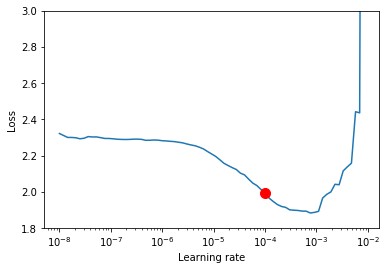

In [59]:
# lr_finder = trainer.lr_find(net)
# fig = lr_finder.plot(suggest=True)

# plt.ylim(1.8,3)

# print(lr_finder.suggestion())

In [71]:
torch.save(net.state_dict(),experiment+'.pt')

In [42]:
def dataset_accuracy(tensor_dataset,targets,net):
    
    net.eval()
    
    net.cpu()
    
    output = net(tensor_dataset)
    
    loss = nn.CrossEntropyLoss()(output,torch.LongTensor(targets)) 

    output = output.data.numpy()
    prediction = np.argmax(output,axis=1)

    n_correct = len(np.where(targets==prediction)[0])
    n_total = len(targets)
    
    if torch.cuda.is_available():
        net.cuda()
    return n_correct/n_total, loss.item()

In [36]:
validation_tensor = torch.stack([valid_ds[i][0] for i in range(len(valid_ds)) ])
validation_label = valid_ds.labels.data.numpy()

In [ ]:
dataset_accuracy(validation_tensor,validation_label, net)